In [12]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

import time



In [13]:
start_time = time.time()
tcurrent   = start_time

# Set golbal parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 545 # original seed: 42
random.seed = seed
np.random.seed = seed

In [14]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [15]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:09<00:00,  3.53it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 39.47it/s]


Done!


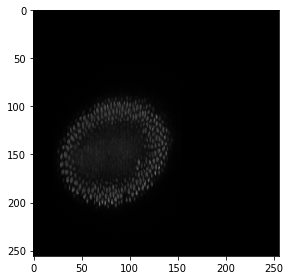

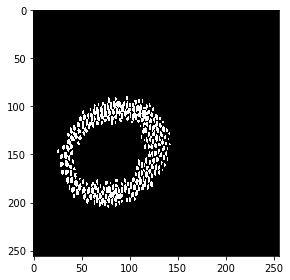

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [17]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [18]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c = Conv2D(256, (3, 3), activation='relu', padding='same') (p5)
c = Conv2D(256, (3, 3), activation='relu', padding='same') (c)

u61 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c)
u61 = concatenate([u61, c5])
c61 = Conv2D(128, (3, 3), activation='relu', padding='same') (u61)
c61 = Conv2D(128, (3, 3), activation='relu', padding='same') (c61)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 8)  224         lambda_2[0][0]                   
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [19]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

# setup
n_epochs  = 100
val_split = 0.10

# fitting
results = model.fit(X_train, Y_train, validation_split=val_split, batch_size=8, epochs=n_epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
600/603 [============================>.] - ETA: 3:51 - loss: 0.6929 - mean_iou: 0.0000e+ - ETA: 3:02 - loss: 0.6916 - mean_iou: 0.2101   - ETA: 2:49 - loss: 0.6901 - mean_iou: 0.28 - ETA: 2:50 - loss: 0.6890 - mean_iou: 0.32 - ETA: 2:49 - loss: 0.6873 - mean_iou: 0.34 - ETA: 2:49 - loss: 0.6860 - mean_iou: 0.36 - ETA: 2:55 - loss: 0.6837 - mean_iou: 0.37 - ETA: 2:50 - loss: 0.6808 - mean_iou: 0.37 - ETA: 2:46 - loss: 0.6783 - mean_iou: 0.38 - ETA: 2:41 - loss: 0.6752 - mean_iou: 0.38 - ETA: 2:38 - loss: 0.6721 - mean_iou: 0.39 - ETA: 2:33 - loss: 0.6680 - mean_iou: 0.39 - ETA: 2:28 - loss: 0.6601 - mean_iou: 0.39 - ETA: 2:23 - loss: 0.6543 - mean_iou: 0.39 - ETA: 2:19 - loss: 0.6388 - mean_iou: 0.40 - ETA: 2:15 - loss: 0.6366 - mean_iou: 0.40 - ETA: 2:12 - loss: 0.6250 - mean_iou: 0.40 - ETA: 2:08 - loss: 0.6119 - mean_iou: 0.40 - ETA: 2:05 - loss: 0.6025 - mean_iou: 0.40 - ETA: 2:02 - loss: 0.5969 - mean_iou: 0.40 - ETA: 2:00 - 

600/603 [============================>.] - ETA: 3:10 - loss: 0.2736 - mean_iou: 0.44 - ETA: 3:08 - loss: 0.2636 - mean_iou: 0.44 - ETA: 3:07 - loss: 0.2572 - mean_iou: 0.44 - ETA: 3:04 - loss: 0.2532 - mean_iou: 0.44 - ETA: 2:58 - loss: 0.2362 - mean_iou: 0.44 - ETA: 2:57 - loss: 0.2403 - mean_iou: 0.44 - ETA: 2:54 - loss: 0.2243 - mean_iou: 0.44 - ETA: 2:51 - loss: 0.2430 - mean_iou: 0.44 - ETA: 2:48 - loss: 0.2536 - mean_iou: 0.44 - ETA: 2:46 - loss: 0.2508 - mean_iou: 0.44 - ETA: 2:46 - loss: 0.2476 - mean_iou: 0.44 - ETA: 2:44 - loss: 0.2509 - mean_iou: 0.44 - ETA: 2:43 - loss: 0.2476 - mean_iou: 0.44 - ETA: 2:42 - loss: 0.2456 - mean_iou: 0.44 - ETA: 2:41 - loss: 0.2468 - mean_iou: 0.44 - ETA: 2:37 - loss: 0.2458 - mean_iou: 0.44 - ETA: 2:35 - loss: 0.2461 - mean_iou: 0.44 - ETA: 2:33 - loss: 0.2402 - mean_iou: 0.44 - ETA: 2:30 - loss: 0.2397 - mean_iou: 0.44 - ETA: 2:27 - loss: 0.2406 - mean_iou: 0.44 - ETA: 2:25 - loss: 0.2444 - mean_iou: 0.44 - ETA: 2:22 - loss: 0.2448 - mean_i

600/603 [============================>.] - ETA: 3:32 - loss: 0.1343 - mean_iou: 0.53 - ETA: 3:19 - loss: 0.1087 - mean_iou: 0.54 - ETA: 3:16 - loss: 0.1033 - mean_iou: 0.54 - ETA: 3:17 - loss: 0.1180 - mean_iou: 0.54 - ETA: 3:18 - loss: 0.1147 - mean_iou: 0.54 - ETA: 3:17 - loss: 0.1260 - mean_iou: 0.54 - ETA: 3:15 - loss: 0.1260 - mean_iou: 0.54 - ETA: 3:13 - loss: 0.1213 - mean_iou: 0.54 - ETA: 3:11 - loss: 0.1244 - mean_iou: 0.54 - ETA: 3:07 - loss: 0.1341 - mean_iou: 0.54 - ETA: 3:03 - loss: 0.1387 - mean_iou: 0.54 - ETA: 3:00 - loss: 0.1373 - mean_iou: 0.54 - ETA: 2:56 - loss: 0.1368 - mean_iou: 0.54 - ETA: 2:53 - loss: 0.1363 - mean_iou: 0.54 - ETA: 2:49 - loss: 0.1344 - mean_iou: 0.54 - ETA: 2:46 - loss: 0.1371 - mean_iou: 0.54 - ETA: 2:42 - loss: 0.1327 - mean_iou: 0.54 - ETA: 2:39 - loss: 0.1298 - mean_iou: 0.54 - ETA: 2:35 - loss: 0.1286 - mean_iou: 0.54 - ETA: 2:32 - loss: 0.1301 - mean_iou: 0.54 - ETA: 2:29 - loss: 0.1299 - mean_iou: 0.54 - ETA: 2:25 - loss: 0.1307 - mean_i

600/603 [============================>.] - ETA: 3:40 - loss: 0.1275 - mean_iou: 0.61 - ETA: 3:29 - loss: 0.1170 - mean_iou: 0.61 - ETA: 3:23 - loss: 0.1176 - mean_iou: 0.61 - ETA: 3:22 - loss: 0.1136 - mean_iou: 0.61 - ETA: 3:21 - loss: 0.1127 - mean_iou: 0.61 - ETA: 3:19 - loss: 0.1190 - mean_iou: 0.61 - ETA: 3:17 - loss: 0.1144 - mean_iou: 0.61 - ETA: 3:14 - loss: 0.1224 - mean_iou: 0.61 - ETA: 3:13 - loss: 0.1230 - mean_iou: 0.61 - ETA: 3:10 - loss: 0.1167 - mean_iou: 0.61 - ETA: 3:07 - loss: 0.1156 - mean_iou: 0.61 - ETA: 3:03 - loss: 0.1118 - mean_iou: 0.61 - ETA: 3:00 - loss: 0.1120 - mean_iou: 0.61 - ETA: 2:56 - loss: 0.1100 - mean_iou: 0.61 - ETA: 2:54 - loss: 0.1099 - mean_iou: 0.61 - ETA: 2:51 - loss: 0.1118 - mean_iou: 0.61 - ETA: 2:48 - loss: 0.1087 - mean_iou: 0.61 - ETA: 2:45 - loss: 0.1098 - mean_iou: 0.61 - ETA: 2:41 - loss: 0.1078 - mean_iou: 0.61 - ETA: 2:38 - loss: 0.1103 - mean_iou: 0.61 - ETA: 2:35 - loss: 0.1103 - mean_iou: 0.61 - ETA: 2:31 - loss: 0.1081 - mean_i

600/603 [============================>.] - ETA: 3:47 - loss: 0.1276 - mean_iou: 0.66 - ETA: 3:47 - loss: 0.1159 - mean_iou: 0.66 - ETA: 3:38 - loss: 0.1073 - mean_iou: 0.66 - ETA: 3:36 - loss: 0.1016 - mean_iou: 0.66 - ETA: 3:30 - loss: 0.0939 - mean_iou: 0.66 - ETA: 3:26 - loss: 0.0866 - mean_iou: 0.66 - ETA: 3:21 - loss: 0.0808 - mean_iou: 0.66 - ETA: 3:16 - loss: 0.0836 - mean_iou: 0.66 - ETA: 3:16 - loss: 0.0840 - mean_iou: 0.66 - ETA: 3:14 - loss: 0.0875 - mean_iou: 0.66 - ETA: 3:12 - loss: 0.0862 - mean_iou: 0.66 - ETA: 3:08 - loss: 0.0857 - mean_iou: 0.66 - ETA: 3:05 - loss: 0.0828 - mean_iou: 0.66 - ETA: 3:03 - loss: 0.0843 - mean_iou: 0.66 - ETA: 3:00 - loss: 0.0833 - mean_iou: 0.66 - ETA: 2:57 - loss: 0.0858 - mean_iou: 0.66 - ETA: 2:54 - loss: 0.0879 - mean_iou: 0.66 - ETA: 2:52 - loss: 0.0890 - mean_iou: 0.66 - ETA: 2:50 - loss: 0.0878 - mean_iou: 0.66 - ETA: 2:46 - loss: 0.0885 - mean_iou: 0.66 - ETA: 2:43 - loss: 0.0889 - mean_iou: 0.66 - ETA: 2:40 - loss: 0.0890 - mean_i

600/603 [============================>.] - ETA: 3:48 - loss: 0.0857 - mean_iou: 0.69 - ETA: 3:35 - loss: 0.0700 - mean_iou: 0.69 - ETA: 3:41 - loss: 0.0799 - mean_iou: 0.69 - ETA: 3:36 - loss: 0.0735 - mean_iou: 0.69 - ETA: 3:32 - loss: 0.0725 - mean_iou: 0.69 - ETA: 3:26 - loss: 0.0733 - mean_iou: 0.69 - ETA: 3:21 - loss: 0.0833 - mean_iou: 0.69 - ETA: 3:19 - loss: 0.0904 - mean_iou: 0.69 - ETA: 3:19 - loss: 0.0889 - mean_iou: 0.69 - ETA: 3:15 - loss: 0.0872 - mean_iou: 0.69 - ETA: 3:12 - loss: 0.0887 - mean_iou: 0.69 - ETA: 3:08 - loss: 0.0845 - mean_iou: 0.69 - ETA: 3:04 - loss: 0.0855 - mean_iou: 0.69 - ETA: 3:02 - loss: 0.0899 - mean_iou: 0.69 - ETA: 2:59 - loss: 0.0887 - mean_iou: 0.69 - ETA: 2:56 - loss: 0.0872 - mean_iou: 0.69 - ETA: 2:53 - loss: 0.0877 - mean_iou: 0.69 - ETA: 2:50 - loss: 0.0895 - mean_iou: 0.69 - ETA: 2:46 - loss: 0.0913 - mean_iou: 0.69 - ETA: 2:43 - loss: 0.0888 - mean_iou: 0.69 - ETA: 2:40 - loss: 0.0880 - mean_iou: 0.69 - ETA: 2:37 - loss: 0.0872 - mean_i

600/603 [============================>.] - ETA: 3:13 - loss: 0.0691 - mean_iou: 0.71 - ETA: 3:13 - loss: 0.0773 - mean_iou: 0.71 - ETA: 3:11 - loss: 0.0734 - mean_iou: 0.71 - ETA: 3:08 - loss: 0.0796 - mean_iou: 0.71 - ETA: 3:08 - loss: 0.0728 - mean_iou: 0.71 - ETA: 3:06 - loss: 0.0774 - mean_iou: 0.71 - ETA: 3:03 - loss: 0.0779 - mean_iou: 0.71 - ETA: 3:00 - loss: 0.0796 - mean_iou: 0.71 - ETA: 2:57 - loss: 0.0776 - mean_iou: 0.71 - ETA: 2:54 - loss: 0.0776 - mean_iou: 0.71 - ETA: 2:52 - loss: 0.0765 - mean_iou: 0.71 - ETA: 2:49 - loss: 0.0750 - mean_iou: 0.71 - ETA: 2:46 - loss: 0.0791 - mean_iou: 0.71 - ETA: 2:44 - loss: 0.0792 - mean_iou: 0.71 - ETA: 2:41 - loss: 0.0786 - mean_iou: 0.71 - ETA: 2:40 - loss: 0.0780 - mean_iou: 0.71 - ETA: 2:39 - loss: 0.0776 - mean_iou: 0.71 - ETA: 2:38 - loss: 0.0796 - mean_iou: 0.71 - ETA: 2:36 - loss: 0.0777 - mean_iou: 0.71 - ETA: 2:34 - loss: 0.0767 - mean_iou: 0.71 - ETA: 2:32 - loss: 0.0757 - mean_iou: 0.71 - ETA: 2:29 - loss: 0.0750 - mean_i

600/603 [============================>.] - ETA: 3:38 - loss: 0.0751 - mean_iou: 0.73 - ETA: 3:33 - loss: 0.0981 - mean_iou: 0.73 - ETA: 3:34 - loss: 0.0968 - mean_iou: 0.73 - ETA: 3:31 - loss: 0.0889 - mean_iou: 0.73 - ETA: 3:38 - loss: 0.0834 - mean_iou: 0.73 - ETA: 3:33 - loss: 0.0811 - mean_iou: 0.73 - ETA: 3:31 - loss: 0.0792 - mean_iou: 0.73 - ETA: 3:26 - loss: 0.0735 - mean_iou: 0.73 - ETA: 3:22 - loss: 0.0736 - mean_iou: 0.73 - ETA: 3:18 - loss: 0.0737 - mean_iou: 0.73 - ETA: 3:14 - loss: 0.0743 - mean_iou: 0.73 - ETA: 3:11 - loss: 0.0725 - mean_iou: 0.73 - ETA: 3:08 - loss: 0.0728 - mean_iou: 0.73 - ETA: 3:04 - loss: 0.0715 - mean_iou: 0.73 - ETA: 3:01 - loss: 0.0733 - mean_iou: 0.73 - ETA: 2:58 - loss: 0.0739 - mean_iou: 0.73 - ETA: 2:55 - loss: 0.0728 - mean_iou: 0.73 - ETA: 2:51 - loss: 0.0751 - mean_iou: 0.73 - ETA: 2:48 - loss: 0.0747 - mean_iou: 0.73 - ETA: 2:44 - loss: 0.0741 - mean_iou: 0.73 - ETA: 2:41 - loss: 0.0726 - mean_iou: 0.73 - ETA: 2:37 - loss: 0.0732 - mean_i

600/603 [============================>.] - ETA: 3:03 - loss: 0.0484 - mean_iou: 0.75 - ETA: 3:08 - loss: 0.0509 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0521 - mean_iou: 0.75 - ETA: 2:59 - loss: 0.0469 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0525 - mean_iou: 0.75 - ETA: 3:04 - loss: 0.0560 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0568 - mean_iou: 0.75 - ETA: 3:02 - loss: 0.0593 - mean_iou: 0.75 - ETA: 3:04 - loss: 0.0620 - mean_iou: 0.75 - ETA: 3:03 - loss: 0.0655 - mean_iou: 0.75 - ETA: 3:00 - loss: 0.0665 - mean_iou: 0.75 - ETA: 2:58 - loss: 0.0708 - mean_iou: 0.75 - ETA: 2:55 - loss: 0.0700 - mean_iou: 0.75 - ETA: 2:53 - loss: 0.0692 - mean_iou: 0.75 - ETA: 2:50 - loss: 0.0678 - mean_iou: 0.75 - ETA: 2:48 - loss: 0.0690 - mean_iou: 0.75 - ETA: 2:46 - loss: 0.0692 - mean_iou: 0.75 - ETA: 2:43 - loss: 0.0698 - mean_iou: 0.75 - ETA: 2:41 - loss: 0.0696 - mean_iou: 0.75 - ETA: 2:39 - loss: 0.0682 - mean_iou: 0.75 - ETA: 2:37 - loss: 0.0684 - mean_iou: 0.75 - ETA: 2:34 - loss: 0.0682 - mean_i

600/603 [============================>.] - ETA: 3:02 - loss: 0.0673 - mean_iou: 0.76 - ETA: 2:50 - loss: 0.0670 - mean_iou: 0.76 - ETA: 2:48 - loss: 0.0784 - mean_iou: 0.76 - ETA: 2:45 - loss: 0.0763 - mean_iou: 0.76 - ETA: 2:43 - loss: 0.0796 - mean_iou: 0.76 - ETA: 2:41 - loss: 0.0750 - mean_iou: 0.76 - ETA: 2:37 - loss: 0.0757 - mean_iou: 0.76 - ETA: 2:35 - loss: 0.0766 - mean_iou: 0.76 - ETA: 2:31 - loss: 0.0743 - mean_iou: 0.76 - ETA: 2:28 - loss: 0.0754 - mean_iou: 0.76 - ETA: 2:25 - loss: 0.0736 - mean_iou: 0.76 - ETA: 2:22 - loss: 0.0708 - mean_iou: 0.76 - ETA: 2:20 - loss: 0.0707 - mean_iou: 0.76 - ETA: 2:17 - loss: 0.0698 - mean_iou: 0.76 - ETA: 2:15 - loss: 0.0683 - mean_iou: 0.76 - ETA: 2:12 - loss: 0.0701 - mean_iou: 0.76 - ETA: 2:10 - loss: 0.0702 - mean_iou: 0.76 - ETA: 2:07 - loss: 0.0702 - mean_iou: 0.76 - ETA: 2:05 - loss: 0.0713 - mean_iou: 0.76 - ETA: 2:03 - loss: 0.0741 - mean_iou: 0.76 - ETA: 2:01 - loss: 0.0740 - mean_iou: 0.76 - ETA: 1:58 - loss: 0.0734 - mean_i

600/603 [============================>.] - ETA: 2:48 - loss: 0.0787 - mean_iou: 0.77 - ETA: 2:43 - loss: 0.0765 - mean_iou: 0.77 - ETA: 2:40 - loss: 0.0728 - mean_iou: 0.77 - ETA: 2:38 - loss: 0.0684 - mean_iou: 0.77 - ETA: 2:35 - loss: 0.0735 - mean_iou: 0.77 - ETA: 2:33 - loss: 0.0738 - mean_iou: 0.77 - ETA: 2:29 - loss: 0.0737 - mean_iou: 0.77 - ETA: 2:28 - loss: 0.0734 - mean_iou: 0.77 - ETA: 2:25 - loss: 0.0763 - mean_iou: 0.77 - ETA: 2:23 - loss: 0.0751 - mean_iou: 0.77 - ETA: 2:20 - loss: 0.0746 - mean_iou: 0.77 - ETA: 2:18 - loss: 0.0717 - mean_iou: 0.77 - ETA: 2:16 - loss: 0.0778 - mean_iou: 0.77 - ETA: 2:14 - loss: 0.0796 - mean_iou: 0.77 - ETA: 2:11 - loss: 0.0785 - mean_iou: 0.77 - ETA: 2:09 - loss: 0.0764 - mean_iou: 0.77 - ETA: 2:07 - loss: 0.0757 - mean_iou: 0.77 - ETA: 2:05 - loss: 0.0781 - mean_iou: 0.77 - ETA: 2:03 - loss: 0.0782 - mean_iou: 0.77 - ETA: 2:00 - loss: 0.0779 - mean_iou: 0.77 - ETA: 1:58 - loss: 0.0780 - mean_iou: 0.77 - ETA: 1:56 - loss: 0.0765 - mean_i

600/603 [============================>.] - ETA: 2:36 - loss: 0.0588 - mean_iou: 0.77 - ETA: 2:41 - loss: 0.0523 - mean_iou: 0.77 - ETA: 2:38 - loss: 0.0508 - mean_iou: 0.77 - ETA: 2:36 - loss: 0.0521 - mean_iou: 0.77 - ETA: 2:34 - loss: 0.0517 - mean_iou: 0.77 - ETA: 2:31 - loss: 0.0576 - mean_iou: 0.77 - ETA: 2:29 - loss: 0.0557 - mean_iou: 0.77 - ETA: 2:26 - loss: 0.0610 - mean_iou: 0.77 - ETA: 2:25 - loss: 0.0654 - mean_iou: 0.77 - ETA: 2:23 - loss: 0.0632 - mean_iou: 0.77 - ETA: 2:22 - loss: 0.0627 - mean_iou: 0.77 - ETA: 2:19 - loss: 0.0654 - mean_iou: 0.77 - ETA: 2:17 - loss: 0.0631 - mean_iou: 0.77 - ETA: 2:16 - loss: 0.0654 - mean_iou: 0.77 - ETA: 2:14 - loss: 0.0673 - mean_iou: 0.77 - ETA: 2:12 - loss: 0.0657 - mean_iou: 0.77 - ETA: 2:09 - loss: 0.0645 - mean_iou: 0.77 - ETA: 2:07 - loss: 0.0667 - mean_iou: 0.77 - ETA: 2:05 - loss: 0.0649 - mean_iou: 0.77 - ETA: 2:03 - loss: 0.0664 - mean_iou: 0.77 - ETA: 2:00 - loss: 0.0671 - mean_iou: 0.77 - ETA: 1:58 - loss: 0.0670 - mean_i

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
thr = 0.50
preds_train_t = (preds_train > thr).astype(np.uint8)
preds_val_t = (preds_val > thr).astype(np.uint8)
preds_test_t = (preds_test > thr).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 6s 96ms/step


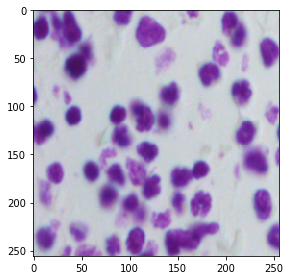

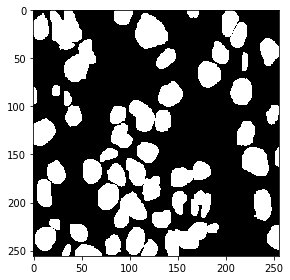

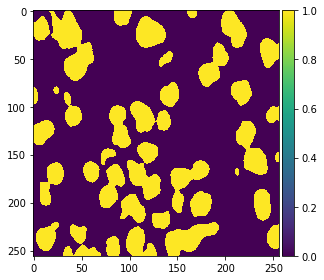

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

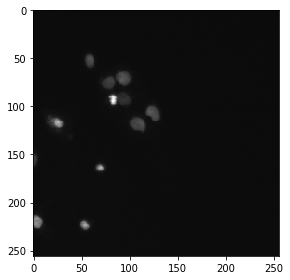

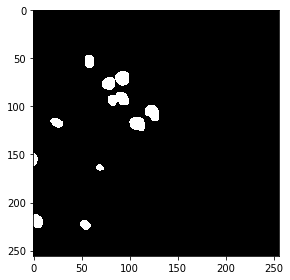

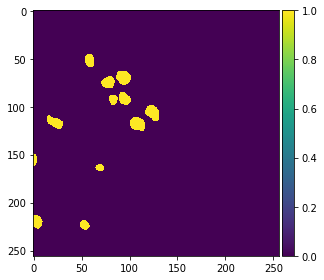

In [22]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [23]:
# Run-length encoding 
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [25]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

fname ='sub-dsbowl nep '+str(n_epochs)+' vsplit '+str(val_split)+' seed '+str(seed)+' thr'+str(thr)+'.csv'

sub.to_csv(fname, index=False)

nm=(time.time() - start_time)/60
print ("Total time %s min" % nm)

Total time 92.11965039571126 min
